# Summary

Parameter space vs. performance. In the manuscript: **Fig. 2C-D**.

---
# Setup


In [1]:
# imports
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from popy.simulation_tools import QLearner, ForagingAgent
from popy.simulation_helpers import simulate_agent
from popy.config import COLORS
import popy.config as cfg



In [2]:
# local functions
def grid_search_RL(env):
    n_samples = 15  # number of samples in the grid search
    alpha_range = np.linspace(.01, .5, n_samples)  # learning rate range

    res_grid_qlearn_inferential = np.zeros(len(alpha_range))  # to store results
        
    for i, alpha in enumerate(alpha_range):
        params_temp = {'alpha': alpha}
        behavior_temp = simulate_agent(QLearner, params=params_temp, env=env, fixed_params={'structure_aware': True})  # simulate inferential Q-learning agent (structure-aware means inferential RL setup)

        # compute proportion of best arm selections
        prop_best_arm = (behavior_temp["best_arm"].values == behavior_temp["action"].values).mean()
        res_grid_qlearn_inferential[i] = prop_best_arm 

    return alpha_range, res_grid_qlearn_inferential

def plot_parameter_grid_RL(alpha_range, res_grid_qlearn_inferential):

    # Set font sizes
    plt.rcParams.update({'font.size': 8})

    # Create a larger figure to accommodate the axis labels and colorbar
    fig, ax = plt.subplots(1, 1, figsize=(4/2.54, 4/2.54))  # Slightly larger to fit everything

    ax.plot(alpha_range, res_grid_qlearn_inferential, color='black')

    # Add parameter points with compact styling
    ka_params = cfg.MODEL_PARAMS_RL['ka']
    po_params = cfg.MODEL_PARAMS_RL['po']

    # plot lines for each parameter set
    ax.axvline(ka_params['alpha'], color=COLORS['ka'])
    ax.axvline(po_params['alpha'], color=COLORS['po'])

    # mark the points
    ax.scatter(ka_params['alpha'],
            np.interp(ka_params['alpha'], alpha_range, res_grid_qlearn_inferential),
            color=COLORS['ka'], s=60, zorder=5, linewidths=1, edgecolors='white', label='KA')
    ax.scatter(po_params['alpha'],
            np.interp(po_params['alpha'], alpha_range, res_grid_qlearn_inferential),
            color=COLORS['po'], s=60, zorder=5, linewidths=1, edgecolors='white', label='PO')

    ax.set_xlabel('Learning Rate (α)')
    ax.set_ylabel('Prob. optimal target')

    ax.set_xlim(0, .5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add compact legend
    ax.legend(frameon=True, loc='upper right', fontsize=6, markerscale=0.8)

    return fig, ax

def grid_search_foraging(env):
    n_samples = 15  # number of samples in the grid search (per parameter)
    alpha_range = np.linspace(.05, .8, n_samples)  # learning rate range
    V0_range = np.linspace(0, .75, n_samples)

    res_grid = np.zeros((len(alpha_range), len(V0_range)))  # to store results

    for i, alpha in enumerate(alpha_range):
        for j, V0 in enumerate(V0_range):
            params_temp = {
                'alpha': alpha,
                'V0': V0
            }
            behavior = simulate_agent(ForagingAgent, params=params_temp, env=env, fixed_params={'reset_on_switch': True})  # simulate foraging agent (reset value on switching)

            # compute proportion of best arm selection
            prop_best_arm = (behavior["best_arm"].values == behavior["action"].values).mean()
            res_grid[i, j] = prop_best_arm 

    return alpha_range, V0_range, res_grid

def plot_parameter_grid_foraging(alpha_range, V0_range, res_grid):

    # Set font sizes
    plt.rcParams.update({'font.size': 8})

    # Create a larger figure to accommodate the axis labels and colorbar
    fig, ax = plt.subplots(1, 1, figsize=(6/2.54, 6/2.54))  # Slightly larger to fit everything

    # Create nice colormap for the heatmap
    cmap = plt.cm.cividis

    im = ax.imshow(res_grid, origin='lower', 
                extent=[V0_range[0], V0_range[-1], alpha_range[0], alpha_range[-1]], 
                aspect='equal', interpolation='gaussian', cmap=cmap)
    # Add colorbar with compact size
    cbar = fig.colorbar(im, ax=ax, fraction=0.04, pad=0.1)
    cbar.set_label('prob. optimal target', fontsize=8)

    # Add contour lines at every 0.1 increment with minimal labels
    levels = np.arange(0, 100, 10)
    contour = ax.contour(
        np.linspace(V0_range[0], V0_range[-1], res_grid.shape[1]),
        np.linspace(alpha_range[0], alpha_range[-1], res_grid.shape[0]), 
        res_grid, levels=levels, colors='white', linewidths=0.5, alpha=0.7
    )
    # Only label a few contours to avoid clutter
    ax.clabel(contour, inline=True, fontsize=6, fmt='%.0f', levels=levels)

    # Add parameter points with compact styling
    ka_params = cfg.MODEL_PARAMS['ka']
    po_params = cfg.MODEL_PARAMS['po']

    ax.scatter(ka_params['V0'], ka_params['alpha'], color=COLORS['ka'], s=50, label='KA', 
            edgecolor='white', linewidth=1, zorder=10)
    ax.scatter(po_params['V0'], po_params['alpha'], color=COLORS['po'], s=50, label='PO', 
            edgecolor='white', linewidth=1, zorder=10)
    
    # Labels
    ax.set_xlabel('Switch threshold (tau)')
    ax.set_ylabel('Learning Rate (α)')

    # Add compact legend
    ax.legend(frameon=True, loc='upper right', fontsize=6, markerscale=0.8)

    return fig, ax


---
# Set up environment

In [3]:
env = gym.make("zsombi/monkey-bandit-task-v0", n_arms=3, max_episode_steps=100_000)

---
# Create figures

## Fig. 2C-D, Parameter space vs fitted model parameters

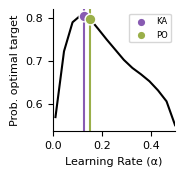

In [4]:
alpha_range, res_grid_qlearn_inferential = grid_search_RL(env)
fig, ax = plot_parameter_grid_RL(alpha_range, res_grid_qlearn_inferential)
plt.show()

In [ ]:
alpha_range, V0_range, res_grid = grid_search_foraging(env)
fig, ax = plot_parameter_grid_foraging(alpha_range, V0_range, res_grid)
plt.show()